## Pre-processing and Visualization

In [11]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


random.seed(21)
np.random.seed(21)

In [9]:
data = pd.read_csv('TimeSeries.csv', encoding = 'utf-8')
data['Water'] = pd.to_numeric(data['Water'])

In [60]:
data

,Year,Water
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413
...,...,...
74,1959,594
75,1960,587
76,1961,587
77,1962,625


In [38]:
def walk_forward_validation(unsplit_data, base_window_size):
    X = []
    Y = []

    while base_window_size < unsplit_data.shape[0]:
        validation_sequence = unsplit_data.iloc[: base_window_size, 1].tolist()
        validation_test = unsplit_data.iloc[base_window_size, 1]
        X.append(validation_sequence)
        Y.append(validation_test)
        base_window_size += 1

    return X, Y

In [58]:
X, Y = walk_forward_validation(data, 3)

XTrain = X[:-10]
YTrain = Y[:-10]
XTest = X[-10:]
YTest = Y[-10:]

## Naive Forecast / Persistence

In [59]:
def naive_forecast(X):
    forecast = []
    
    for x in X:
        forecast.append(x[-1])
    
    return forecast

In [64]:
print('Naive Forecast Evaluation')

YTrainPred = naive_forecast(XTrain)
print('Training RMSE: ', mean_squared_error(YTrain, YTrainPred, squared = False))

YTestPred = naive_forecast(XTest)
print('Testing RMSE: ', mean_squared_error(YTest, YTestPred, squared = False))

Naive Forecast Evaluation
Training RMSE:  34.92350949076446
Testing RMSE:  17.190113437671084


## Summary Statistics and Plots

### Line Plot

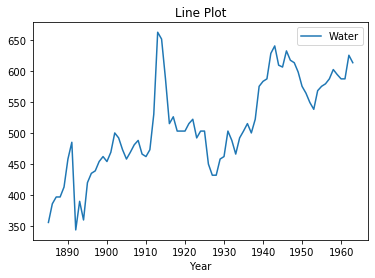

In [66]:
data.plot.line(x = 'Year', y = 'Water', title = 'Line Plot')

### Density Plot

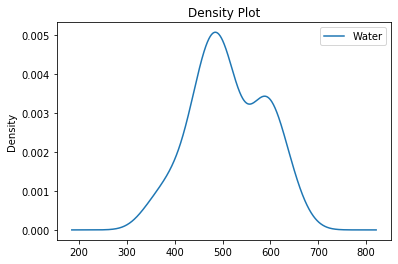

In [74]:
data['Water'].plot.kde(title = 'Density Plot', legend = 'Water')

### Box-and-Whisker Plot

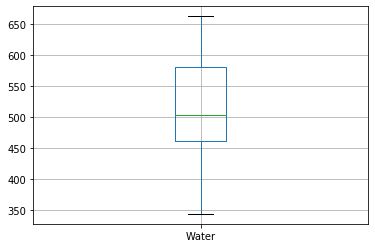

In [80]:
data.boxplot(column=['Water'])

## ARIMA Modelling